In [41]:
##Load data from 2017 experiment and populate data arrays for headlines and responses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
no_ind=98
f=pd.read_json('data.txt','r')
before_resp=[[] for i in range(len(f))] #responses before headlines
after_resp=[[] for i in range(len(f))] #responses after headlines
no_for=[[] for i in range(len(f))] #evidence for preferred belief
no_against=[[] for i in range(len(f))] #evidence against preferred belief
time_dict_list=[[dict() for x in range(10)] for y in range(no_ind)] #time of viewing headlines

for i in range(len(f)):
    jj=0
    for j in range(4,43):
        a=f.iloc[i][0][j]
        #collect statement responses from json data file
        if a['internal_node_id'].endswith('-2.0'):
            if a['statementResponse']==100:
                after_resp[i].append(99)
            else:
                after_resp[i].append(a['statementResponse'])
        elif a['internal_node_id'].endswith('0.0'):
            if a['statementResponse']==100:
                before_resp[i].append(99)
            else:
                before_resp[i].append(a['statementResponse'])
        elif a['internal_node_id'].endswith('1.0'):
            no_for[i].append(len(a['alphaNews'])+a['firstForAgainst'].count('for'))
            no_against[i].append(len(a['premierNews'])+a['firstForAgainst'].count('against'))
            for item in a['alphaNews']:
                time_dict_list[i][jj][str(item)]='for'
            for item in a['premierNews']:
                time_dict_list[i][jj][str(item)]='against'
            for k in range(len(a['firstNews'])):
                time_dict_list[i][jj][str(a['firstNews'][k])] = a['firstForAgainst'][k]
            jj+=1

#remove conspiracy theory questions
for i in range(98):
    before_resp[i].remove(before_resp[i][1])
    after_resp[i].remove(after_resp[i][1])
    no_for[i].remove(no_for[i][1])
    no_against[i].remove(no_against[i][1])
    time_dict_list[i].remove(time_dict_list[i][1])

In [66]:
#create array of rewards for the sequence of headlines for RL model
rewards=np.zeros((no_ind,9,15))
for i in range(no_ind):
    for j in range(9):
        k=0
        for key in sorted(time_dict_list[i][j].keys()):
            if time_dict_list[i][j][key]=='for':
                rewards[i][j][k]=1
            k+=1

In [43]:
#Create arrays for evidence in favour and against each statement for each participant
no_true=np.zeros((98,9))
no_false=np.zeros((98,9))
for i in range(98):
    for j in range(9):
        if before_resp[i][j]>=50:
            no_true[i][j]=no_for[i][j]
            no_false[i][j]=no_against[i][j]
        else:
            no_true[i][j]=no_against[i][j]
            no_false[i][j]=no_for[i][j]
            

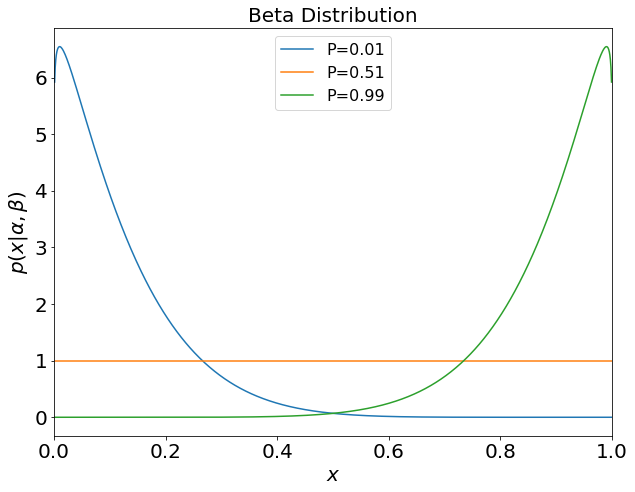

In [67]:
## This produces an example beta prior for any given values of belief strength
from scipy.stats import beta
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 7.5))
x = np.linspace(0, 1, 1002)[1:-1]
i=0
for y in [0.01,0.51,0.99]:
    i+=1
    def equations(p):
        a,b = p
        return ((a-1)/(a+b-2)-y,1/(2*abs(50-100*y))-a*b/((a+b+1)*(a+b)**2))
    res = least_squares(equations, (5, 5), bounds = ((1, 1), (np.inf, np.inf)))
    a,b=res.x
    dist= beta(a,b)
    plt.plot(x, dist.pdf(x),label='P='+str(y))
    plt.legend(prop={'size': 16})
    
plt.xlim(0, 1)

plt.rc('font',size=20)
plt.rc('axes',titlesize=20)
plt.rc('axes',labelsize=20)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\alpha,\beta)$')
plt.title('Beta Distribution')

plt.show()

In [69]:
#code for unbiased Bayesian update (MODEL 1)
no_ind=98
from scipy.optimize import least_squares
from scipy.stats import beta
import math
x = np.linspace(0, 1, 1002)[1:-1]
mode_new=np.zeros((no_ind,len(before_resp[0])))
for i in range(len(before_resp)):
    for j in range(len(before_resp[i])):
        y=before_resp[i][j]*0.01
        if y!=0.5:
            def equations(p):
                a,b = p
                return ((a-1)/(a+b-2)-y,1/(2*abs(50-100*y+0.01))-a*b/((a+b+1)*(a+b)**2))
            res = least_squares(equations, (5, 2), bounds = ((1, 1), (math.inf, math.inf)))
            a,b=res.x
            dist= beta(a,b) # prior distribution from estimated alpha, beta
            likelihood=x**no_true[i][j]*(1-x)**(15-no_true[i][j]) #likelihood given by evidence
            distnew=beta(a+no_true[i][j],b+(15-no_true[i][j])) # posterior distribution
            mode_new[i][j]=(a+no_true[i][j]-1)/(a+b+15-2) # MAP estimate of posterior belief
            

In [70]:
#Calculate confirmation bias by comparing with Bayesian
opt_pos=mode_new*100
confirm=np.zeros((98,9))
for i in range(98):
    for j in range(9):
        if before_resp[i][j]>50:
            confirm[i][j]=after_resp[i][j]-opt_pos[i][j]
        elif before_resp[i][j]<50:
            confirm[i][j]=opt_pos[i][j]-after_resp[i][j]

Ttest_1sampResult(statistic=18.430931360536515, pvalue=2.3988230426599408e-63)
12.64898501661848
1.3442779495649073


Text(0,0.5,'Number of Updates')

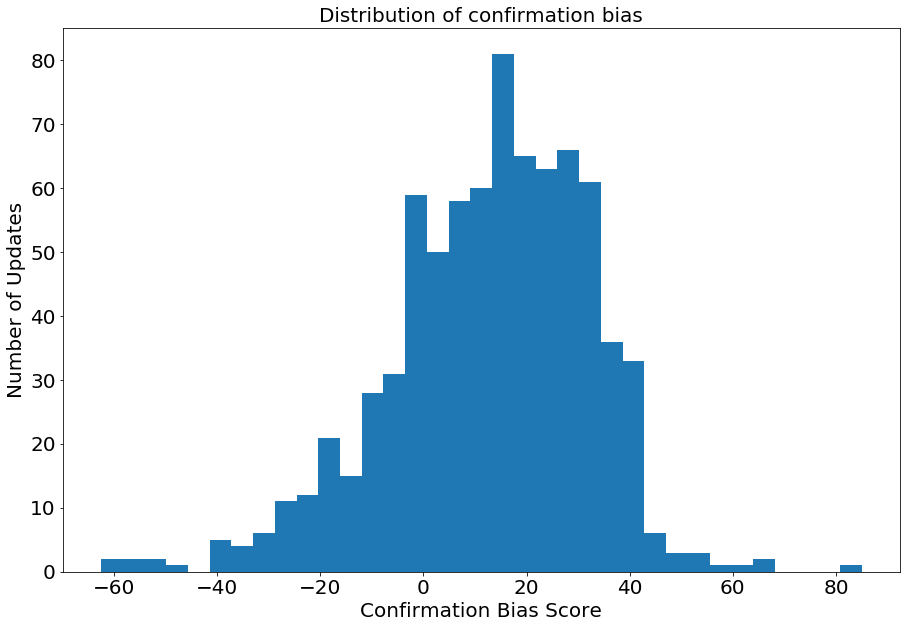

In [71]:
#Plot distribution of confirmation bias scores (excluding neutral beliefs)
from scipy import stats
zero_ind=[]
for i in range(len(np.concatenate(confirm))):
    if np.ndarray.flatten(np.asarray(before_resp))[i]==50:
        zero_ind.append(i)
confirm_adj=np.delete(np.concatenate(confirm),zero_ind)
print(stats.ttest_1samp(confirm_adj,0))
print(np.mean(confirm_adj))
print(1.96*np.std(confirm_adj)/np.sqrt(len(confirm_adj)))
plt.figure(figsize=(15,10))
plt.hist(confirm_adj,35)
plt.title('Distribution of confirmation bias')
plt.xlabel('Confirmation Bias Score')
plt.ylabel('Number of Updates')

SpearmanrResult(correlation=0.8271037833775416, pvalue=2.05692895349034e-222)


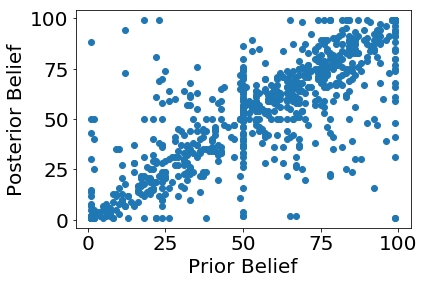

In [75]:
#Plot prior and posterior beliefs 
from scipy.stats import pearsonr
plt.scatter(np.concatenate(before_resp),np.concatenate(after_resp))
print(stats.spearmanr(np.concatenate(before_resp),np.concatenate(after_resp)))
plt.xlabel('Prior Belief')
plt.ylabel('Posterior Belief')
plt.show()

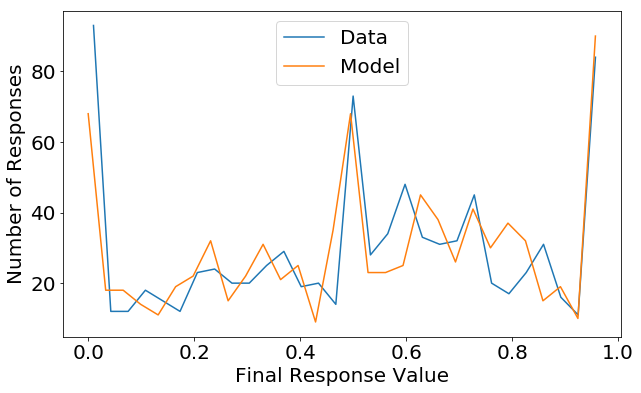

SpearmanrResult(correlation=0.3320582216016678, pvalue=0.0008367505232111189)
Ks_2sampResult(statistic=0.08163265306122447, pvalue=0.0052228240293853015)
0.0979217091594815
0.06885570506163285


Ttest_1sampResult(statistic=2.773115486371255, pvalue=0.006658939864641937)

In [77]:
#MODEL 2 Fitting

#assign alpha and beta values 
alpha_arr=np.zeros((98,9))
beta_arr=np.zeros((98,9))
for i in range(len(before_resp)):
    for j in range(len(before_resp[i])):
        y=before_resp[i][j]*0.01
        if y!=0.5:
            def equations(p):
                a,b = p
                return ((a-1)/(a+b-2)-y,1/(2*abs(50-100*y))-a*b/((a+b+1)*(a+b)**2))
            res = least_squares(equations, (5, 2), bounds = ((1, 1), (math.inf, math.inf)))
            #print(res.x)
            #print(confidence[i][j])
            a,b=res.x
            alpha_arr[i][j]=a
            beta_arr[i][j]=b

#weight arrays for all participants
weight_conf=np.zeros(98)
weight_disc=np.zeros(98)
ind_confirm=np.zeros(98)
weight_evid=np.zeros(98)
ll=[]
for i in range(98):
    def equation(x):
        eqns=np.zeros(9)
        for j in range(9):
            if before_resp[i][j]>=50:
                eqns[j]=(0.01*after_resp[i][j]-(alpha_arr[i][j]+x[0]*x[1]*no_true[i][j]-1)
                         /(alpha_arr[i][j]+beta_arr[i][j]+x[0]*(x[1]*no_true[i][j] + x[2]*no_false[i][j])-2))
            elif before_resp[i][j]<50:
                eqns[j]=(0.01*after_resp[i][j]-(alpha_arr[i][j]+x[0]*x[2]*no_true[i][j]-1)
                         /(alpha_arr[i][j]+beta_arr[i][j]+x[0]*(x[2]*no_true[i][j] + x[1]*no_false[i][j])-2))
        return eqns
    res= least_squares(equation,0.5*np.ones(3),bounds=([0,0,0],[np.inf,1,1])) # least square fit to responses
    ll.append(res.cost)
    weight_conf[i]=res.x[1]
    weight_disc[i]=res.x[2]
    weight_evid[i]=res.x[0]

#simulate responses usng model
def sim_resp(i):
    sim=np.zeros(9)
    for j in range(9):
        if before_resp[i][j]>=50:
            sim[j]=(alpha_arr[i][j]+res.x[0]*res.x[1]*no_true[i][j]-1)/(alpha_arr[i][j]+beta_arr[i][j]+res.x[0]*(res.x[1]*no_true[i][j] + res.x[2]*no_false[i][j])-2)
        elif before_resp[i][j]<50:
            sim[j]=(alpha_arr[i][j]+res.x[0]*res.x[2]*no_true[i][j]-1)/(alpha_arr[i][j]+beta_arr[i][j]+res.x[0]*(res.x[2]*no_true[i][j] + res.x[1]*no_false[i][j])-2)
    return sim
model_resp=np.zeros((no_ind,9))
for i in range(no_ind):
    model_resp[i]=sim_resp(i)
    
#plot actual and simulated responses
plt.figure(figsize=(10,6))
y_1,bins_1=np.histogram(np.ndarray.flatten(0.01*np.asarray(after_resp)),30)
plt.plot(bins_1[:len(bins_1)-1],y_1,label='Data')
plt.xlabel('Final Response Value')
y_2,bins_2=np.histogram(np.ndarray.flatten(np.asarray(model_resp)),30)
plt.plot(bins_2[:len(bins_2)-1],y_2,label='Model')
plt.ylabel('Number of Responses')
plt.legend()
plt.show()

#participant bias for model 1:
for i in range(98):
    ind_confirm[i]=np.sum(confirm[i])/(np.count_nonzero(confirm[i]))
    
#bias for model 2:
new_confirm=(weight_conf-weight_disc)

#correlation with model 1
print(stats.spearmanr(new_confirm,ind_confirm))

#kolmogorov-smirnov test:
print(stats.ks_2samp(np.ndarray.flatten(0.01*np.asarray(after_resp)),np.ndarray.flatten(model_resp)))

#significance of model 2 confirmation bias:
print(np.mean(new_confirm))
print(1.96*np.std(new_confirm)/np.sqrt(len(new_confirm)))
stats.ttest_1samp(new_confirm,0)

In [81]:
#AIC calculation, k=3 parameters + vairance of data since we used least sqiare fit
AIC=[]
k=4
for i in range(no_ind):
    AIC.append(2*k+9*np.log(ll[i]))

In [82]:
BIC=[]
for i in range(no_ind):
    BIC.append(4*np.log(9)+9*np.log(ll[i]))

Text(0,0.5,'Number of Participants')

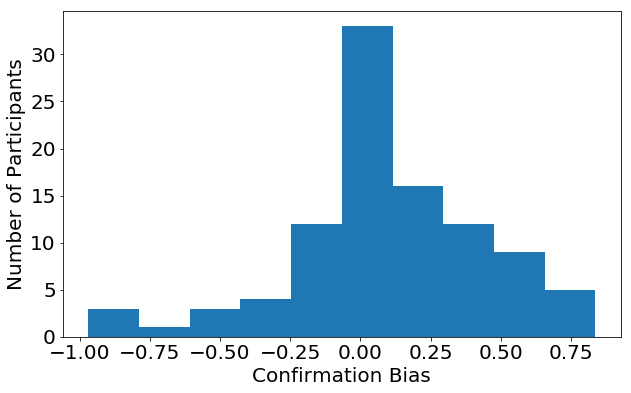

In [83]:
plt.figure(figsize=(10,6))
plt.hist(new_confirm)
plt.xlabel('Confirmation Bias')
plt.ylabel('Number of Participants')

In [20]:
#count confirmation biased participants
print(np.sum(new_confirm>0))
print(np.sum(new_confirm<0))
biased2=[]
for i in range(no_ind):
    if new_confirm[i]>0:
        biased2.append(i)

64
34


Parameter Recovery

Generate Simulated Data

In [85]:
weight_c_sim=np.zeros((100,no_ind))
weight_d_sim=np.zeros((100,no_ind))
before_sim=np.random.rand(100,no_ind,16)
alpha_arr=np.zeros((100,no_ind,16))
beta_arr=np.zeros((100,no_ind,16))
after_arr=np.zeros((100,no_ind,16))
rewards_sim=np.random.choice([0, 1], size=(100,no_ind,16,15), p=[1./2, 1./2])
for i in range(no_ind):
    #fit parameters 100 times for each participant
    for k in range(100):
        for j in range(16):
            no_true=np.count_nonzero(rewards_sim[k][i][j])
            no_false=15-no_true
            y=before_sim[k][i][j]*0.01
            if y!=0.5:
                def equations(p):
                    a,b = p
                    return ((a-1)/(a+b-2)-y,1/(2*abs(50-100*y))-a*b/((a+b+1)*(a+b)**2))
                res = least_squares(equations, (5, 2), bounds = ((1, 1), (math.inf, math.inf)))
                #print(res.x)
                #print(confidence[i][j])
                a,b=res.x
                alpha_arr[k][i][j]=a
                beta_arr[k][i][j]=b
            if before_sim[k][i][j]>=50:
                after_arr[k][i][j]=(alpha_arr[k][i][j]+weight_evid[i]*weight_conf[i]*no_true-1)/(alpha_arr[k][i][j]+beta_arr[k][i][j]+weight_evid[i]*(weight_conf[i]*no_true + weight_disc[i]*no_false)-2)
            elif before_sim[k][i][j]<50:
                after_arr[k][i][j]=(alpha_arr[k][i][j]+weight_evid[i]*weight_disc[i]*no_true-1)/(alpha_arr[k][i][j]+beta_arr[k][i][j]+weight_evid[i]*(weight_disc[i]*no_true + weight_conf[i]*no_false)-2)
    


Fit Simulated Data

In [84]:
weight_conf_sim=np.zeros((100,no_ind))
weight_disc_sim=np.zeros((100,no_ind))
weight_evid_sim=np.zeros((100,no_ind))
for k in range(100):
    for i in range(98):
        def equation(x):
            eqns=np.zeros(16)
            for j in range(16):
                no_true=np.count_nonzero(rewards_sim[k][i][j])
                no_false=15-no_true
                if before_sim[k][i][j]>=50:
                    eqns[j]=(after_arr[k][i][j]-(alpha_arr[k][i][j]+x[0]*x[1]*no_true-1)
                             /(alpha_arr[k][i][j]+beta_arr[k][i][j]+x[0]*(x[1]*no_true + x[2]*no_false)-2))
                elif before_sim[k][i][j]<50:
                    eqns[j]=(after_arr[k][i][j]-(alpha_arr[k][i][j]+x[0]*x[2]*no_true-1)
                             /(alpha_arr[k][i][j]+beta_arr[k][i][j]+x[0]*(x[2]*no_true + x[1]*no_false)-2))
            return eqns
        res= least_squares(equation,0.5*np.ones(3),bounds=([0,0,0],[np.inf,1,1]))
    #print(res.x,np.mean(confirm[i]))
        weight_conf_sim[k][i]=res.x[1]
        weight_disc_sim[k][i]=res.x[2]
        weight_evid_sim[k][i]=res.x[0]

IndexError: invalid index to scalar variable.

In [23]:
#compare mean simulated parameters with fit parameters:
print(stats.pearsonr(np.mean(weight_conf_sim,axis=0),weight_conf))
print(stats.pearsonr(np.mean(weight_disc_sim,axis=0),weight_disc))
print(stats.pearsonr(np.mean(weight_evid_sim,axis=0),weight_evid))
print(stats.pearsonr(np.mean(weight_evid_sim,axis=0),weight_conf))
print(stats.pearsonr(np.mean(weight_evid_sim,axis=0),weight_disc))
print(stats.pearsonr(np.mean(weight_conf_sim,axis=0),weight_evid))
print(stats.pearsonr(np.mean(weight_conf_sim,axis=0),weight_disc))
print(stats.pearsonr(np.mean(weight_disc_sim,axis=0),weight_evid))
print(stats.pearsonr(np.mean(weight_disc_sim,axis=0),weight_conf))

(0.05144480243678866, 0.6149104469868945)
(-0.0024793097137918835, 0.980669918593291)
(-0.033906384429563084, 0.740308574039015)
(0.04337616504014501, 0.6714984679141465)
(-0.015549110517285443, 0.879216496649465)
(-0.05111429172221325, 0.617187560172199)
(0.04446913285058767, 0.6637157035248729)
(-0.013621162699304643, 0.8940995213608052)
(0.08015971648617093, 0.4326747108687097)


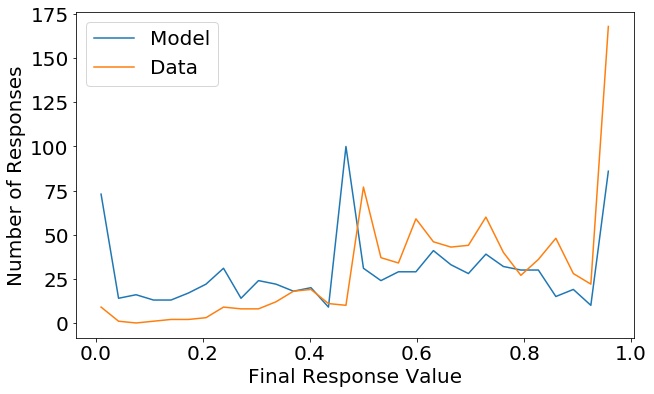

6.604340706631225
Ks_2sampResult(statistic=0.08390022675736962, pvalue=0.003735986729083685)
Ttest_indResult(statistic=0.881400225155087, pvalue=0.37822144890046605)
9
16.69135918606824
(0.8400242453647639, 6.475482315332457e-236)
0.010000000000000009


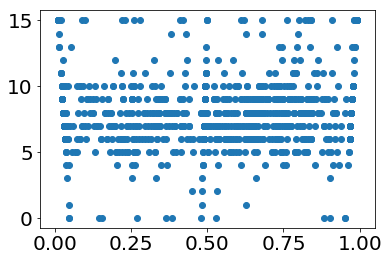

In [39]:
from scipy.optimize import least_squares
from scipy.special import logit,expit

#define RL update with rho_ev=evidence learning rate (inv. conservatism), 
#rho_c and rho_d = conf and disc learning rates
def update(rho_ev,rho_c,rho_d,reward,V_0):
    V=V_0
    for i in range(len(reward)):
        if reward[i]==1:
            V= V + rho_ev*rho_c*(reward[i]-V)
        elif reward[i]==0:
            V= V + rho_ev*rho_d*(reward[i]-V)
    return V

value_array=np.zeros((no_ind,9))
after_array=np.zeros((no_ind,9))
for i in range(no_ind):
    for j in range(9):
        if before_resp[i][j]>=50:
            value_array[i][j]=before_resp[i][j]
            after_array[i][j]=after_resp[i][j]
        else:
            value_array[i][j]=100-before_resp[i][j]
            after_array[i][j]=100-after_resp[i][j]
#rewrite value as probability
value_array=0.01*value_array
#arrays for weights and confirmation score:
confirm_rl=np.zeros(no_ind)
alpha_con=[]
alpha_dis=[]
conserve=[]
ll=[]
for i in range(no_ind):
    #fit responses to result of RL update
    def equation(x):
        eqns=np.zeros(9)
        for j in range(9):
            eqns[j]=(0.01*after_array[i][j]-update(x[0],x[1],x[2],rewards[i][j],value_array[i][j]))
        return eqns
    res= least_squares(equation,[0.01,0.5,0.5],bounds=([0,0,0],[1,1,1]))
    ll.append(res.cost)
    alpha_con.append(res.x[1])
    alpha_dis.append(res.x[2])
    conserve.append(res.x[0])
    confirm_rl[i]=(res.x[1]-res.x[2]) # conf bias = diff in learning rates

#simulate model responses
def sim_resp(i):
    sim=np.zeros(9)
    for j in range(9):
        if before_resp[i][j]>=50:
            sim[j]=update(res.x[0],res.x[1],res.x[2],rewards[i][j],value_array[i][j])
        else:
            sim[j]=1-update(res.x[0],res.x[1],res.x[2],rewards[i][j],value_array[i][j])
    return sim

model_resp=np.zeros((no_ind,9))
after_arr=np.zeros((no_ind,9))
for i in range(no_ind):
        model_resp[i]=sim_resp(i)
        for j in range(9):
            if before_resp[i][j]>=50:
                after_arr[i][j]=after_array[i][j]
            else:
                after_arr[i][j]=100-after_array[i][j]
#plot model and actual response distributions
plt.figure(figsize=(10,6))
y_1,bins_1=np.histogram(np.ndarray.flatten(model_resp),30)
plt.plot(bins_1[:len(bins_1)-1],y_1,label='Model')
y_2,bins_2=np.histogram(np.ndarray.flatten(0.01*after_array),30)
plt.plot(bins_2[:len(bins_2)-1],y_2,label='Data')
plt.xlabel('Final Response Value')
plt.ylabel('Number of Responses')
plt.legend()
plt.show()

#KS test
print(stats.ks_2samp(np.ndarray.flatten(0.01*after_arr),np.ndarray.flatten(model_resp)))
cost=np.sqrt(np.sum((np.asarray(model_resp)-np.asarray(0.01*after_resp))**2)/(no_ind*9))
print(cost)
print(stats.pearsonr(np.ndarray.flatten(model_resp), np.ndarray.flatten(0.01*after_arr)))

Text(0,0.5,'Frequency')

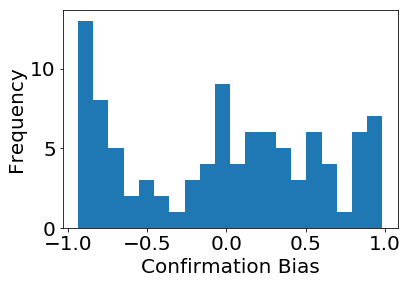

In [86]:
plt.hist(confirm_rl,20)
plt.xlabel('Confirmation Bias')
plt.ylabel('Frequency')

In [26]:
print(np.mean(confirm_rl))
print(np.std(confirm_rl)*1.96/len(confirm_rl))

-0.022247296653853832
0.012188371610981184


In [27]:
#AIC calculation, again k=3+1 for least squares
AIC_2=[]
k=4
for i in range(no_ind):
    AIC_2.append(2*k+9*np.log(ll[i]))
print(AIC_2)

[-40.157641207329625, -76.67642953873357, -70.42477863504878, -58.518524496576234, -44.22124279106822, -19.123526867963605, 0.25003775155991725, -23.032273669434694, -32.15883595698439, -26.68411486458227, -53.6615300357978, -16.178449591640977, -96.72240966578059, -39.8585107242082, -16.723994392493797, -31.291516051974135, -56.720980228067845, -22.9345396971434, -42.79774601215709, -135.24707450861092, -43.534456550537506, -45.43152832022993, -37.6560885351039, -50.60432669573533, -21.132389179925614, -42.84535933789628, -37.34544929779928, -76.43125350840222, -38.0283941414058, -90.80438153623146, -88.48939182013879, -47.42230535458638, -46.055833865845706, -32.23143127967697, -28.68316486367503, -55.374897433649394, -34.577346861086205, -57.613313733001206, -17.039937690571012, -69.28551307498853, -34.74430770202945, -42.24731487665088, -32.09338735805122, -28.183288950386157, -30.51718639322872, -47.12779229617858, -10.094250739588531, -31.7646801072882, -64.27444133021119, -90.41

In [28]:
BIC_2=[]
for i in range(no_ind):
    BIC_2.append(4*np.log(9)+9*np.log(ll[i]))
#print(BIC)

In [29]:
print(np.sum(np.array(AIC)-np.array(AIC_2)>0))
print(np.sum(np.array(BIC)-np.array(BIC_2)>0))
print(np.mean(AIC)-np.mean(AIC_2))

60
60
5.61893938293786


In [30]:
#Simulate data and refit for parameter recovery
alpha_c_sim=np.zeros((100,no_ind))
alpha_d_sim=np.zeros((100,no_ind))
con_sim=np.zeros((100,no_ind))
for k in range(100):
    print(k)
    bef=np.random.rand(no_ind,9)
    y=np.zeros((no_ind,9))
    rewards_sim=np.random.choice([0, 1], size=(no_ind,9,15), p=[1./2, 1./2])
    for i in range(len(bef)):
        a_c=alpha_con[i]
        a_d=alpha_dis[i]
        c=conserve[i]
        for j in range(9):
            if bef[i][j]<0.5:
                bef[i][j]=1-bef[i][j]
            y[i][j]=update(c,a_c,a_d,rewards_sim[i][j],bef[i][j])+0.01*np.random.randn()
        def equation(x):
            eqns=np.zeros(9)
            for j in range(9):
                eqns[j]=(y[i][j]-update(x[0],x[1],x[2],rewards_sim[i][j],bef[i][j]))
            return eqns
        res= least_squares(equation,[0.01,0.2,0.2],bounds=([0,0,0],[1,1,1]))
        #print(res.x)
        #print(res.cost)
        alpha_c_sim[k][i]=res.x[1]
        alpha_d_sim[k][i]=res.x[2]
        con_sim[k][i]=res.x[0]

0
1
2


KeyboardInterrupt: 

In [ ]:
#calculate correlations between simulated and fitted paramters
print(stats.pearsonr(np.mean(alpha_c_sim,axis=0),alpha_con))
print(stats.pearsonr(np.mean(alpha_c_sim,axis=0),alpha_dis))
print(stats.pearsonr(np.mean(alpha_c_sim,axis=0),conserve))
print(stats.pearsonr(np.mean(alpha_d_sim,axis=0),alpha_dis))
print(stats.pearsonr(np.mean(alpha_d_sim,axis=0),alpha_con))
print(stats.pearsonr(np.mean(alpha_d_sim,axis=0),conserve))
print(stats.pearsonr(np.mean(con_sim,axis=0),conserve))
print(stats.pearsonr(np.mean(con_sim,axis=0),alpha_con))
print(stats.pearsonr(np.mean(con_sim,axis=0),alpha_dis))

-0.022247296653853832
0.12065872304844959
48
50
0
98


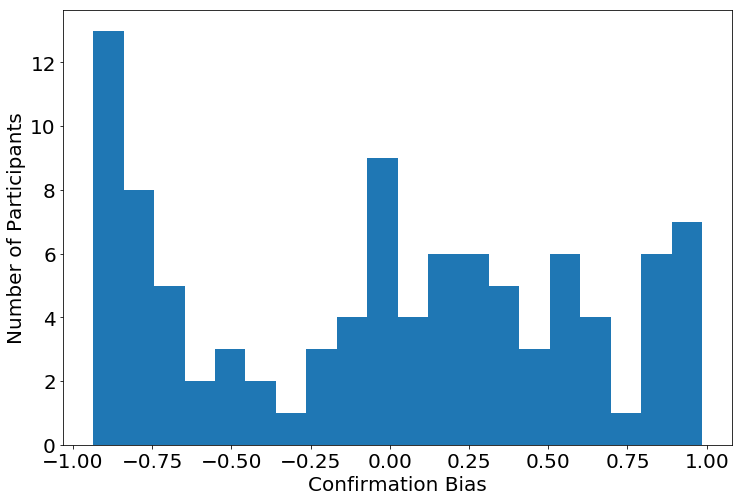

In [37]:
plt.figure(figsize=(12,8))
plt.hist(confirm_rl,20)
plt.xlabel('Confirmation Bias')
plt.ylabel('Number of Participants')
print(np.mean(confirm_rl))
print(np.std(confirm_rl)*1.96/np.sqrt(len(confirm_rl)))
print(np.sum(confirm_rl>0))
print(np.sum(confirm_rl<0))
print(np.sum(confirm_rl==0))
print(len(confirm_rl))

In [35]:
#significance testing for rl bias measure
print(stats.ttest_1samp(confirm_rl,0))
print(stats.ttest_ind(alpha_con,alpha_dis))

Ttest_1sampResult(statistic=-0.3595401719139772, pvalue=0.7199725784420297)
Ttest_indResult(statistic=-0.45273742119072286, pvalue=0.6512437227548062)


SpearmanrResult(correlation=0.3968721509222245, pvalue=5.2124241498943704e-05)


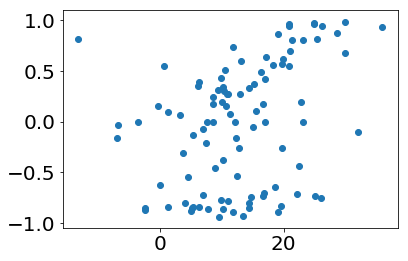

In [192]:
#correlation between model 1 and 3
print(stats.spearmanr(ind_confirm,confirm_rl))
plt.scatter(ind_confirm,confirm_rl)

SpearmanrResult(correlation=0.5358720807910792, pvalue=1.2997895263067965e-08)


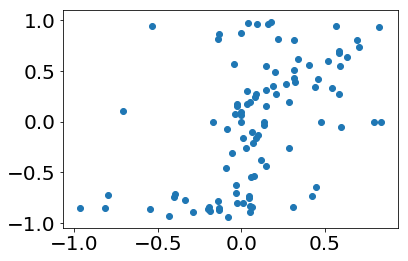

In [189]:
#correlation between model 2 and 3
print(stats.sr(new_confirm,confirm_rl))
plt.scatter(new_confirm,confirm_rl)

In [ ]:
biased_new=[]
biased_rl=[]
for i in range(98):
    if new_confirm[i]>0:
        biased_new.append(i)
    if confirm_rl[i]>0:
        biased_rl.append(i)

In [61]:
#correlation between conservatism measures
stats.spearmanr(onserve,weight_evid)

SpearmanrResult(correlation=0.5975619863690554, pvalue=8.263495953622157e-11)

In [188]:
#number of participants classified as biased under each model
both=0
rl=0
bayes=0
neither=0
for i in range(no_ind):
    if confirm_rl[i]>0 and new_confirm[i]>0:
        both+=1
    elif confirm_rl[i]>0:
        rl+=1
    elif new_confirm[i]>0:
        bayes+=1
    else:
        neither+=1
print(both,bayes,rl,neither)

37 27 11 23
